## IDS Project
#### This project will create an IDS Detection Machine Learning model, which will predict DoS attacks and flag them as such. 
By Chadi Amzil

In [86]:
!pip install pandas
!pip install seaborn
!pip install pyarrow
!pip install xgboost
!pip install catboost
!pip install flask
!pip install catboost
!pip install hdbscan
!pip install sklearn
!pip install numpy
!pip install matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import glob
import joblib
from sklearn.preprocessing import LabelEncoder


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [59]:
#Supressing warnings generated by the code
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [60]:
# setting pd to display all maximum amount of rows,
# with a scrollable option
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Extract

In [61]:
#Defining the extract function
def extract() -> pd.DataFrame:
    """This functions combines all the csv and json files into a dataframe

    Args:
        None: The function reads all csv, json files, 
        & parquet files in the working directory
        
    Returns:
        data (pd.DataFrame): All data sources combined in a single dataframe
    """
    ## create an empty dataframe to hold all the data
    # The columns' names are given based on an earlier exploration of a csv file
    data = []
    ## glob.glob('*.csv') returns ['ids_0.csv', 'ids_1.csv', 'ids_2.csv']
    # 
    for csvfile in glob.glob('*.csv'):
        #adding the extracted csv files into the dataframe
        data.append(pd.read_csv(csvfile))

    
    ## glob.glob('*.json') 
    # returns ['ids_3.json', 'ids_4.json', 'ids_7.json', 'ids_9.json', 'ids_10.json]
    for jsonfile in glob.glob('*.json'):
        # adding the extracted json files into the dataframe
        data.append(pd.read_json(jsonfile, lines=True))


    ## glob.glob('*.parquet') 
    # returns ['ids_5.parquet', 'ids_6.parquet', 'ids_8.parquet', 'ids_11.parquet']
    for parquetfile in glob.glob('*.parquet'):
        # adding the extracted json files into the dataframe
        data.append(pd.read_parquet(parquetfile))
    # concatenate the loaded data to the data frame
    data = pd.concat(data, ignore_index=True)
    return data


In [62]:
# Print the documentation of the extract() function
print(extract.__doc__)

This functions combines all the csv and json files into a dataframe

    Args:
        None: The function reads all csv, json files, 
        & parquet files in the working directory

    Returns:
        data (pd.DataFrame): All data sources combined in a single dataframe
    


In [63]:
# Extracting the dataframe
data = extract()
# Printing head to confirm extraction
data.head()


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443,87261,1,1,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,523,2,0,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,94304,1,1,56,338,56,56,56.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,207,2,2,84,246,42,42,42.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,123,69022032,2,2,96,96,48,48,48.0,0.0,...,32,22276.0,0.0,22276,22276,69000000.0,0.0,69000000,69000000,BENIGN


In [64]:
#Confriming shape of extracting dataframe
data.shape

(61128, 79)

### Transform

In [65]:
# check if any of the columns has a NaN (missing) value
data.isna().sum()

 Destination Port                 0
 Flow Duration                    0
 Total Fwd Packets                0
 Total Backward Packets           0
Total Length of Fwd Packets       0
 Total Length of Bwd Packets      0
 Fwd Packet Length Max            0
 Fwd Packet Length Min            0
 Fwd Packet Length Mean           0
 Fwd Packet Length Std            0
Bwd Packet Length Max             0
 Bwd Packet Length Min            0
 Bwd Packet Length Mean           0
 Bwd Packet Length Std            0
Flow Bytes/s                    111
 Flow Packets/s                  33
 Flow IAT Mean                    0
 Flow IAT Std                     0
 Flow IAT Max                     0
 Flow IAT Min                     0
Fwd IAT Total                     0
 Fwd IAT Mean                     0
 Fwd IAT Std                      0
 Fwd IAT Max                      0
 Fwd IAT Min                      0
Bwd IAT Total                     0
 Bwd IAT Mean                     0
 Bwd IAT Std                

##### Two columns have NaN values, "Flow Bytes/s" & " Flow Packets/s"
##### Also note that some columns have an extra space string at the start, which may cause an errors in the code.

In [66]:
# Exploring data types
data.dtypes

 Destination Port                 int64
 Flow Duration                    int64
 Total Fwd Packets                int64
 Total Backward Packets           int64
Total Length of Fwd Packets       int64
 Total Length of Bwd Packets      int64
 Fwd Packet Length Max            int64
 Fwd Packet Length Min            int64
 Fwd Packet Length Mean         float64
 Fwd Packet Length Std          float64
Bwd Packet Length Max             int64
 Bwd Packet Length Min            int64
 Bwd Packet Length Mean         float64
 Bwd Packet Length Std          float64
Flow Bytes/s                    float64
 Flow Packets/s                 float64
 Flow IAT Mean                  float64
 Flow IAT Std                   float64
 Flow IAT Max                     int64
 Flow IAT Min                     int64
Fwd IAT Total                     int64
 Fwd IAT Mean                   float64
 Fwd IAT Std                    float64
 Fwd IAT Max                      int64
 Fwd IAT Min                      int64


In [67]:
# I will downcast the integers for memory efficiency
data = data.apply(lambda col: pd.to_numeric(col, downcast='integer')
                  if col.dtype =='int64' else col)
data.dtypes

 Destination Port                 int32
 Flow Duration                    int32
 Total Fwd Packets                int16
 Total Backward Packets           int16
Total Length of Fwd Packets       int32
 Total Length of Bwd Packets      int32
 Fwd Packet Length Max            int16
 Fwd Packet Length Min            int16
 Fwd Packet Length Mean         float64
 Fwd Packet Length Std          float64
Bwd Packet Length Max             int16
 Bwd Packet Length Min            int16
 Bwd Packet Length Mean         float64
 Bwd Packet Length Std          float64
Flow Bytes/s                    float64
 Flow Packets/s                 float64
 Flow IAT Mean                  float64
 Flow IAT Std                   float64
 Flow IAT Max                     int32
 Flow IAT Min                     int32
Fwd IAT Total                     int32
 Fwd IAT Mean                   float64
 Fwd IAT Std                    float64
 Fwd IAT Max                      int32
 Fwd IAT Min                      int32


In [68]:
# Checking how many unique values are available
print(data.nunique())

 Destination Port                 886
 Flow Duration                  39517
 Total Fwd Packets                104
 Total Backward Packets           115
Total Length of Fwd Packets      1879
 Total Length of Bwd Packets     1206
 Fwd Packet Length Max            872
 Fwd Packet Length Min            100
 Fwd Packet Length Mean          3875
 Fwd Packet Length Std           7011
Bwd Packet Length Max             666
 Bwd Packet Length Min            251
 Bwd Packet Length Mean          1263
 Bwd Packet Length Std           1288
Flow Bytes/s                    34585
 Flow Packets/s                 42564
 Flow IAT Mean                  33160
 Flow IAT Std                   14954
 Flow IAT Max                   13986
 Flow IAT Min                    4348
Fwd IAT Total                   11221
 Fwd IAT Mean                   13856
 Fwd IAT Std                    11993
 Fwd IAT Max                    11090
 Fwd IAT Min                     4922
Bwd IAT Total                   14833
 Bwd IAT Mea

In [69]:
# Comparing values of two header length table,
# to verify whether it's a duplicate
identical = data[' Fwd Header Length'].equals(data[' Fwd Header Length.1'])
identical

True

In [70]:
def transform(data: pd.DataFrame) -> pd.DataFrame:
     """This function performs the transformations:
    1. Removing duplicates from the extracted data
    2. Handling missing data in "Flow Bytes/s" & "Flow Packets/s
    3. No metric conversion needed, since the data is not metric
      Args:
        data (pd.DataFrame): extracted data ready for transformations

    Returns:
        pd.DataFrame: transformed data
        """
    # Removing duplicates 
     data = data.drop_duplicates()
     # Remove blank spaces in front of colomn names
     data.columns = data.columns.str.strip()
     # Removing the duplicate column "Fwd Header Length.1"
     data.drop(columns='Fwd Header Length.1')
     ## Fill missing values only in these columns with 0, 
     ## Since missing value in flow bytes and flow packets signify no traffic
     data['Flow Bytes/s'] = data['Flow Bytes/s'].fillna(0)
     data['Flow Packets/s'] = data['Flow Packets/s'].fillna(0)

     # return transformed data
     return data


In [71]:
# Print the documentation of the transform() function
print(transform.__doc__)

This function performs the transformations:
    1. Removing duplicates from the extracted data
    2. Handling missing data in "Flow Bytes/s" & "Flow Packets/s
    3. No metric conversion needed, since the data is not metric
      Args:
        data (pd.DataFrame): extracted data ready for transformations

    Returns:
        pd.DataFrame: transformed data
        


In [72]:
#Executing transform function
data = transform(data)


## Load

In [73]:
# Storing the transformed dataset as a CSV file to provide a simple format
# for preprocessing and data manipulation
def loadcsv(data: pd.DataFrame) -> None:
    """This function loads the argument dataframe into a csv file

    Args:
        data (pd.DataFrame): extracted and transformed dataframe
    """
    data.to_csv('ids_transformed.csv', index= False)

In [74]:
# Print the documentation of the loadcsv() function
print(loadcsv.__doc__)

This function loads the argument dataframe into a csv file

    Args:
        data (pd.DataFrame): extracted and transformed dataframe
    


In [75]:
# Executing loadcsv function
data= loadcsv(data)

### Exploring the Data

In [76]:
df = pd.read_csv('ids_transformed.csv')
df.head(20)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443,87261,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0000,0,0,0.000000e+00,0.00000,0,0,BENIGN
1,443,523,2,0,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0000,0,0,0.000000e+00,0.00000,0,0,BENIGN
2,53,94304,1,1,56,338,56,56,56.000000,0.000000,...,20,0.0,0.0000,0,0,0.000000e+00,0.00000,0,0,BENIGN
3,53,207,2,2,84,246,42,42,42.000000,0.000000,...,20,0.0,0.0000,0,0,0.000000e+00,0.00000,0,0,BENIGN
4,123,69022032,2,2,96,96,48,48,48.000000,0.000000,...,32,22276.0,0.0000,22276,22276,6.900000e+07,0.00000,69000000,69000000,BENIGN
5,49260,3,2,0,37,0,31,6,18.500000,17.677670,...,20,0.0,0.0000,0,0,0.000000e+00,0.00000,0,0,BENIGN
6,45198,99451595,6,6,11595,371,5792,0,1932.500000,2989.558881,...,32,16982.0,0.0000,16982,16982,9.930000e+07,0.00000,99300000,99300000,BENIGN
7,53,61533,1,1,42,122,42,42,42.000000,0.000000,...,32,0.0,0.0000,0,0,0.000000e+00,0.00000,0,0,BENIGN
8,53,66577,2,2,82,146,41,41,41.000000,0.000000,...,32,0.0,0.0000,0,0,0.000000e+00,0.00000,0,0,BENIGN
9,443,83830,7,8,6150,3362,5471,0,878.571429,2033.968195,...,32,0.0,0.0000,0,0,0.000000e+00,0.00000,0,0,BENIGN


In [77]:
# Identifying unique labels
df['Label'].unique()

array(['BENIGN', 'DoS Hulk', 'DoS Slowhttptest', 'Heartbleed',
       'DoS GoldenEye'], dtype=object)

In [78]:
# Listing how many samples belong to each class
df['Label'].value_counts()

Label
DoS Hulk            22065
DoS GoldenEye       16250
DoS Slowhttptest     5228
BENIGN               4957
Heartbleed             11
Name: count, dtype: int64

In [79]:
# Combining all DoS labels under one
df['Label'] = df['Label'].replace(['DoS Hulk', 'DoS GoldenEye', 'DoS Slowhttptest'], 'DoS')
# Dropping heartbleed since we only have 11 values
df= df[df['Label'] != 'Heartbleed']
# Confirming new labels 
df['Label'].value_counts()

Label
DoS       43543
BENIGN     4957
Name: count, dtype: int64

<Axes: xlabel='Label', ylabel='count'>

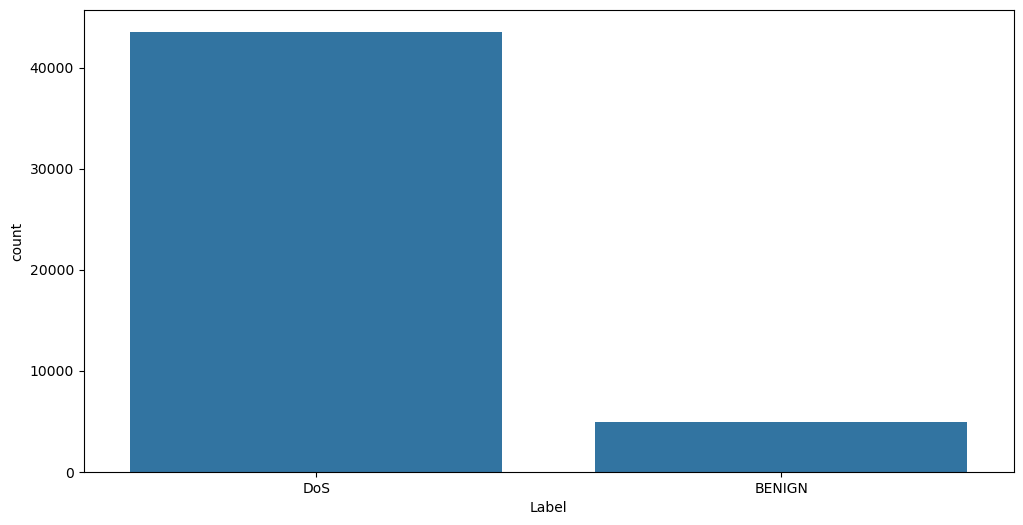

In [80]:
# Creating a bar plot on the distrubtion of class
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='Label', order=df['Label'].value_counts().index)

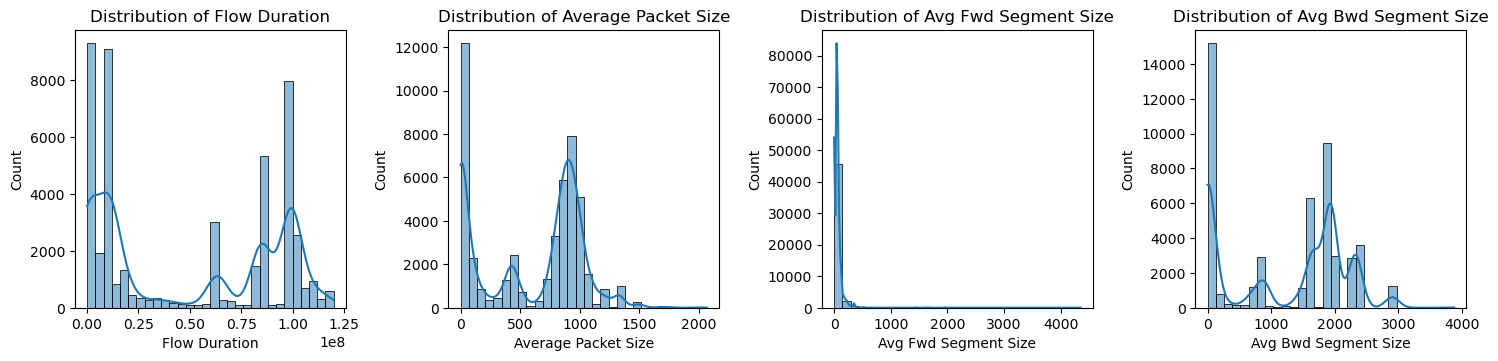

In [81]:
# Determining traffic volume using Flow Duration 'Average Packet Size','Avg Fwd Segment Size', 'Avg Bwd Segment Size'
traffic_volume_columns = [
    'Flow Duration',
    'Average Packet Size',
    'Avg Fwd Segment Size',
    'Avg Bwd Segment Size'
]
# Creating a new DataFrame with only the traffic volume columns
traffic_volume_df = df[traffic_volume_columns]
traffic_volume_df.head()
traffic_volume_df.describe()
# Visualize the distribution of traffic volume features
plt.figure(figsize=(15,10))
for i, column in enumerate(traffic_volume_columns):
    plt.subplot(3, 4, i+1)
    sns.histplot(traffic_volume_df[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

In [82]:
df['Label'].unique()

array(['BENIGN', 'DoS'], dtype=object)

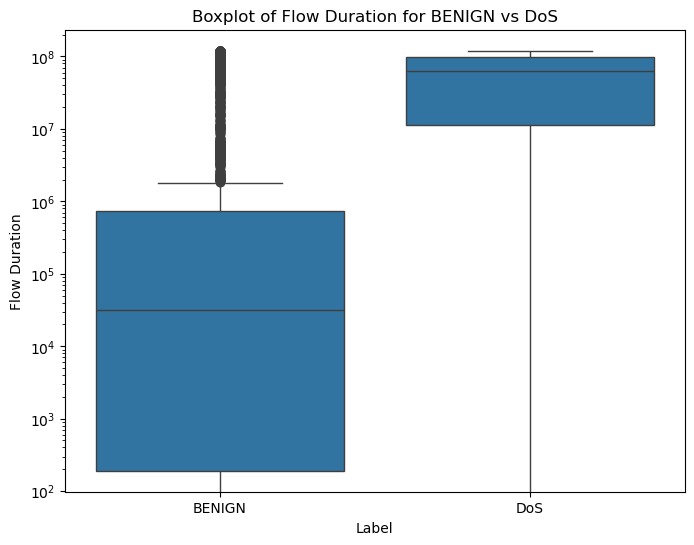

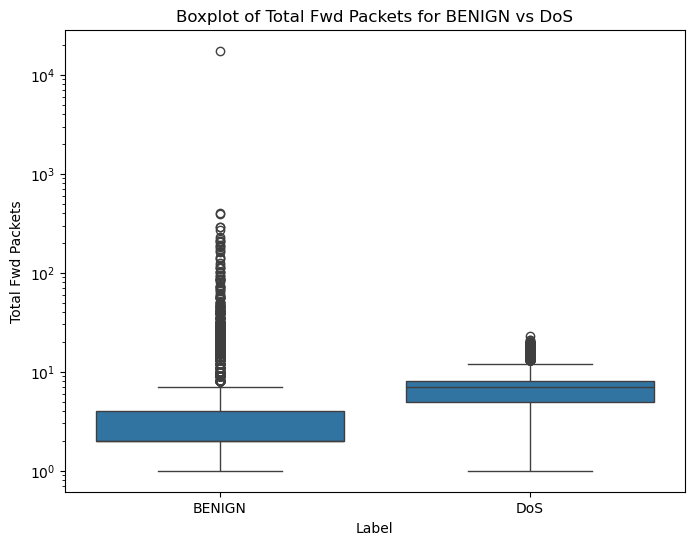

In [83]:
# Perform Per label comparisons, Boxplots of Flow Duration, Total Fwd Packets for: BENIGN vs each attack type. 
# Look for: Attacks that send more packets/sec, Very short vs very long flows.

attack_types = df['Label'].unique()
metrics = ['Flow Duration', 'Total Fwd Packets']
for attack in attack_types:
    if attack != 'BENIGN':
        for metric in metrics:
            plt.figure(figsize=(8, 6))
            sns.boxplot(x='Label', y=metric, data=df[df['Label'].isin(['BENIGN', attack])])
            plt.title(f'Boxplot of {metric} for BENIGN vs {attack}')
            plt.yscale('log')  # Use log scale for better visualization
            plt.show()


## Data Preprocessing

In [84]:
# Checking for columns with inf values
np.isinf(df.select_dtypes(include='number')).any()


Destination Port               False
Flow Duration                  False
Total Fwd Packets              False
Total Backward Packets         False
Total Length of Fwd Packets    False
Total Length of Bwd Packets    False
Fwd Packet Length Max          False
Fwd Packet Length Min          False
Fwd Packet Length Mean         False
Fwd Packet Length Std          False
Bwd Packet Length Max          False
Bwd Packet Length Min          False
Bwd Packet Length Mean         False
Bwd Packet Length Std          False
Flow Bytes/s                    True
Flow Packets/s                  True
Flow IAT Mean                  False
Flow IAT Std                   False
Flow IAT Max                   False
Flow IAT Min                   False
Fwd IAT Total                  False
Fwd IAT Mean                   False
Fwd IAT Std                    False
Fwd IAT Max                    False
Fwd IAT Min                    False
Bwd IAT Total                  False
Bwd IAT Mean                   False
B

In [85]:
# Dropping subflow columns because they, all we need is the total flow,
subflow_cols = [c for c in df.columns if c.startswith("Subflow")]
df=df.drop(columns=subflow_cols)
# Dropping the Destination ports, since that's more of an ID to avoid overfitting
df=df.drop(columns='Destination Port')
# Dropping the Flow Bytes/s & Flow Packets/s columns since they contain inf values
cols_to_drop=['Flow Bytes/s','Flow Packets/s']
df = df.drop(columns=cols_to_drop)


In [87]:
# Encoding the label column
le = LabelEncoder()
df['Label_enc'] = le.fit_transform(df['Label'])
print("\nLabel encoding mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name} -> {i}")
print("\nFirst 10 encoded labels:")
print(df[['Label', 'Label_enc']].head(10))


Label encoding mapping:
BENIGN -> 0
DoS -> 1

First 10 encoded labels:
    Label  Label_enc
0  BENIGN          0
1  BENIGN          0
2  BENIGN          0
3  BENIGN          0
4  BENIGN          0
5  BENIGN          0
6  BENIGN          0
7  BENIGN          0
8  BENIGN          0
9  BENIGN          0
